In [26]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# ======================================================
# A) Load + sample data (100 rows per month-folder)
# ======================================================

base_dir = os.getcwd()
sampled_dfs = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    # Skip if not a directory or not a month folder
    if not os.path.isdir(folder_path) or " " not in folder:
        continue

    csv_path = os.path.join(folder_path, "T_ONTIME_REPORTING.csv")

    if os.path.exists(csv_path):
        try:
            df_month = pd.read_csv(csv_path)

            sample_size = min(300, len(df_month))
            sampled = df_month.sample(n=sample_size, random_state=42)

            sampled_dfs.append(sampled)

        except Exception as e:
            print(f"Error reading {csv_path}: {e}")

if sampled_dfs:
    df = pd.concat(sampled_dfs, ignore_index=True)
    print("Loaded combined df shape:", df.shape)
    print(df.head())
else:
    raise RuntimeError("No data sampled. Check folder structure / file names.")

    


Loaded combined df shape: (3600, 24)
   YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK                FL_DATE  \
0  2025        2      4             6            7   4/6/2025 12:00:00 AM   
1  2025        2      4            18            5  4/18/2025 12:00:00 AM   
2  2025        2      4            21            1  4/21/2025 12:00:00 AM   
3  2025        2      4            25            5  4/25/2025 12:00:00 AM   
4  2025        2      4            25            5  4/25/2025 12:00:00 AM   

   OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_NM  ...  \
0             5683.0              12478    JFK        New York  ...   
1             2923.0              11537    ELM        New York  ...   
2              781.0              12478    JFK        New York  ...   
3             2307.0              11292    DEN        Colorado  ...   
4             1114.0              11298    DFW           Texas  ...   

   DEST_CITY_NAME  DEST_STATE_NM  CRS_DEP_TIME DEP_TIME CRS_ARR_TIME ARR_

In [27]:
# ======================================================
# B) Time conversion helpers + delay features
# ======================================================

def hhmm_to_minutes(x):
    """Convert HHMM (e.g. 1325) -> minutes since midnight."""
    try:
        x = int(float(str(x).strip()))
        h, m = x // 100, x % 100
        if m >= 60:
            return np.nan
        return h * 60 + m
    except:
        return np.nan

# Actual vs scheduled arrival delay
df["ARR_TIME_MIN"] = df["ARR_TIME"].apply(hhmm_to_minutes)
df["CRS_ARR_TIME_MIN"] = df["CRS_ARR_TIME"].apply(hhmm_to_minutes)
df["ARR_DELAY_MIN"] = df["ARR_TIME_MIN"] - df["CRS_ARR_TIME_MIN"]

# Actual vs scheduled departure delay
df["DEP_TIME_MIN"] = df["DEP_TIME"].apply(hhmm_to_minutes)
df["CRS_DEP_TIME_MIN"] = df["CRS_DEP_TIME"].apply(hhmm_to_minutes)
df["DEP_DELAY_MIN"] = df["DEP_TIME_MIN"] - df["CRS_DEP_TIME_MIN"]

In [28]:
# ======================================================
# C) Drop columns you don't want
# ======================================================

cols_to_drop = [
    "FL_DATE", "ARR_DEL15", "FLIGHTS", "DEST_CITY_NAME", "ORIGIN_STATE_NM",
    "DEST_AIRPORT_SEQ_ID", "DEST_CITY_MARKET_ID", "ARR_TIME_BLK"
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])




In [29]:
# ======================================================
# D) Holiday + cyclical scheduled departure time features
# ======================================================

df["Holiday?"] = (
    ((df["MONTH"] == 12) & (df["DAY_OF_MONTH"] >= 20)) |  # Dec 20–31
    ((df["MONTH"] == 1) & (df["DAY_OF_MONTH"] <= 5))   |  # Jan 1–5
    (df["MONTH"].isin([7, 8]))                         # July & August
).astype(int)

# Encode scheduled departure time (CRS_DEP_TIME_MIN) as cyclical features
df["DEP_TIME_sin"] = np.sin(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)
df["DEP_TIME_cos"] = np.cos(2 * np.pi * df["CRS_DEP_TIME_MIN"] / 1440)

# Optional route feature (kept because you created it)
df["ROUTE"] = df["ORIGIN"].astype(str) + "_" + df["DEST"].astype(str)

In [30]:
# ======================================================
# E) Classification target
#    Here: departure delay >= 15 minutes
#    (If you want ARR delay instead, change DEP_DELAY_MIN -> ARR_DELAY_MIN)
# ======================================================

DELAY_THRESHOLD_MIN = 15
df = df.dropna(subset=["DEP_DELAY_MIN"]).copy()
df["DELAYED_15"] = (df["DEP_DELAY_MIN"] >= DELAY_THRESHOLD_MIN).astype(int)

y = df["DELAYED_15"]


In [31]:
# ======================================================
# F) Build features (with OneHot for categorical)
# ======================================================

# Numeric features
numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DAY_OF_MONTH",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos",
    "OP_CARRIER_FL_NUM"
]

# Categorical features to one-hot encode
cat_features = ["ORIGIN", "DEST", "OP_CARRIER_FL_NUM"]

# Drop rows with missing feature values (important before encoding)
df = df.dropna(subset=numeric_features + cat_features + ["DELAYED_15"]).copy()
y = df["DELAYED_15"]

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_cat = encoder.fit_transform(df[cat_features])
X_cat = pd.DataFrame(
    X_cat,
    columns=encoder.get_feature_names_out(cat_features),
    index=df.index
)

# Combine numeric + categorical
X = pd.concat([df[numeric_features], X_cat], axis=1)

print("Final feature matrix:", X.shape)
print("Class balance:", y.value_counts(normalize=True).round(3))

Final feature matrix: (3536, 2882)
Class balance: DELAYED_15
0    0.785
1    0.215
Name: proportion, dtype: float64


In [32]:
# ======================================================
# G) Train/test split (stratified)
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
# ======================================================
# H) Train Random Forest Classifier
# ======================================================

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [34]:
# ======================================================
# I) Evaluate with classification metrics
# ======================================================

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Metrics (DELAYED_15) ===")
print(f"Accuracy:           {accuracy_score(y_test, y_pred):.3f}")
print(f"Balanced Accuracy:  {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (delay):  {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall (delay):     {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1-score:           {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"ROC-AUC:            {roc_auc_score(y_test, y_proba):.3f}")

print("\nConfusion Matrix [ [TN FP], [FN TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=["On-time (<15m)", "Delayed (>=15m)"],
    digits=3
))





=== Classification Metrics (DELAYED_15) ===
Accuracy:           0.653
Balanced Accuracy:  0.608
Precision (delay):  0.318
Recall (delay):     0.529
F1-score:           0.397
ROC-AUC:            0.618

Confusion Matrix [ [TN FP], [FN TP] ]:
[[381 174]
 [ 72  81]]

Classification Report:
                 precision    recall  f1-score   support

 On-time (<15m)      0.841     0.686     0.756       555
Delayed (>=15m)      0.318     0.529     0.397       153

       accuracy                          0.653       708
      macro avg      0.579     0.608     0.577       708
   weighted avg      0.728     0.653     0.678       708



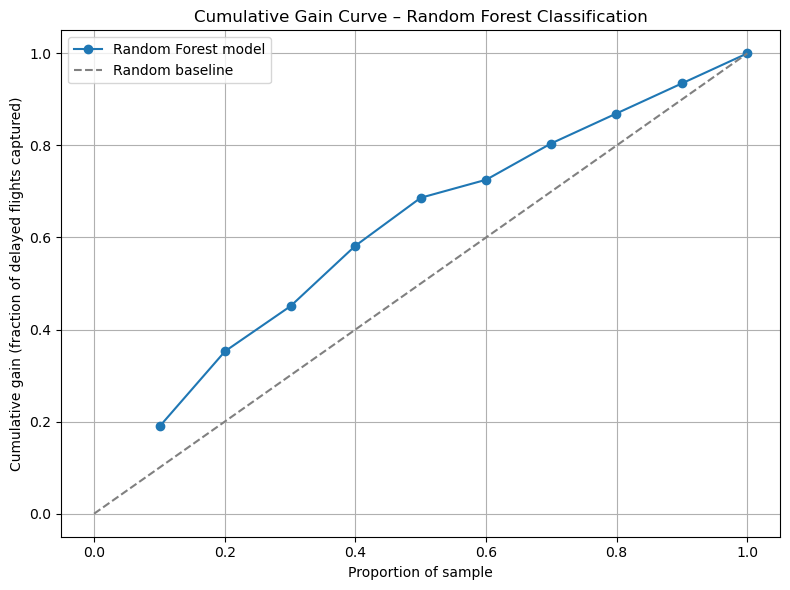

In [35]:
import matplotlib.pyplot as plt

# =========================
# 8) Cumulative Gain Curve
# =========================

# X-axis: percentage of sample contacted
gain_table["cum_perc_samples"] = gain_table["cum_n"] / gain_table["n"].sum()

plt.figure(figsize=(8, 6))
plt.plot(
    gain_table["cum_perc_samples"],
    gain_table["cum_gain"],
    marker="o",
    label="Random Forest model"
)

# Baseline (random model)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="gray",
    label="Random baseline"
)

plt.xlabel("Proportion of sample")
plt.ylabel("Cumulative gain (fraction of delayed flights captured)")
plt.title("Cumulative Gain Curve – Random Forest Classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# ======================================================
# F) Build features (with OneHot for categorical)
# ======================================================

# Numeric features
numeric_features = [
    "MONTH",
    "DAY_OF_WEEK",
    "DAY_OF_MONTH",
    "DISTANCE",
    "DEP_TIME_sin",
    "DEP_TIME_cos",
]

# Categorical features to one-hot encode
cat_features = ["ORIGIN", "DEST"]

# Drop rows with missing feature values (important before encoding)
df = df.dropna(subset=numeric_features + cat_features + ["DELAYED_15"]).copy()
y = df["DELAYED_15"]

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_cat = encoder.fit_transform(df[cat_features])
X_cat = pd.DataFrame(
    X_cat,
    columns=encoder.get_feature_names_out(cat_features),
    index=df.index
)

# Combine numeric + categorical
X = pd.concat([df[numeric_features], X_cat], axis=1)

print("Final feature matrix:", X.shape)
print("Class balance:", y.value_counts(normalize=True).round(3))


Final feature matrix: (3536, 465)
Class balance: DELAYED_15
0    0.785
1    0.215
Name: proportion, dtype: float64


In [37]:
# ======================================================
# G) Train/test split (stratified)
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [38]:
# ======================================================
# H) Train Random Forest Classifier
# ======================================================

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [39]:
# ======================================================
# I) Evaluate with classification metrics
# ======================================================

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Classification Metrics (DELAYED_15) ===")
print(f"Accuracy:           {accuracy_score(y_test, y_pred):.3f}")
print(f"Balanced Accuracy:  {balanced_accuracy_score(y_test, y_pred):.3f}")
print(f"Precision (delay):  {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall (delay):     {recall_score(y_test, y_pred, zero_division=0):.3f}")
print(f"F1-score:           {f1_score(y_test, y_pred, zero_division=0):.3f}")
print(f"ROC-AUC:            {roc_auc_score(y_test, y_proba):.3f}")

print("\nConfusion Matrix [ [TN FP], [FN TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=["On-time (<15m)", "Delayed (>=15m)"],
    digits=3
))









=== Classification Metrics (DELAYED_15) ===
Accuracy:           0.661
Balanced Accuracy:  0.592
Precision (delay):  0.312
Recall (delay):     0.471
F1-score:           0.375
ROC-AUC:            0.641

Confusion Matrix [ [TN FP], [FN TP] ]:
[[396 159]
 [ 81  72]]

Classification Report:
                 precision    recall  f1-score   support

 On-time (<15m)      0.830     0.714     0.767       555
Delayed (>=15m)      0.312     0.471     0.375       153

       accuracy                          0.661       708
      macro avg      0.571     0.592     0.571       708
   weighted avg      0.718     0.661     0.683       708



In [40]:
# =========================
# 7) Cumulative Gain Table (Deciles)
#    Sort by predicted probability (highest first)
# =========================
gain_df = pd.DataFrame({
    "y_true": y_test.reset_index(drop=True),
    "y_proba": pd.Series(y_proba).reset_index(drop=True)
}).sort_values("y_proba", ascending=False).reset_index(drop=True)

gain_df["decile"] = pd.qcut(gain_df.index + 1, 10, labels=False) + 1  # 1..10

total_positives = gain_df["y_true"].sum()

gain_table = (
    gain_df.groupby("decile")
    .agg(
        n=("y_true", "size"),
        positives=("y_true", "sum"),
        avg_proba=("y_proba", "mean")
    )
    .reset_index()
)

gain_table["cum_n"] = gain_table["n"].cumsum()
gain_table["cum_positives"] = gain_table["positives"].cumsum()
gain_table["cum_gain"] = gain_table["cum_positives"] / (total_positives if total_positives > 0 else 1)

gain_table["lift"] = (gain_table["positives"] / gain_table["n"]) / (total_positives / len(gain_df) if len(gain_df) > 0 else 1)

print("\n=== Cumulative Gain Table (by decile, sorted by predicted delay probability) ===")
print(gain_table)



=== Cumulative Gain Table (by decile, sorted by predicted delay probability) ===
   decile   n  positives  avg_proba  cum_n  cum_positives  cum_gain      lift
0       1  71         29   0.602680     71             29  0.189542  1.890086
1       2  71         25   0.559330    142             54  0.352941  1.629384
2       3  71         15   0.522567    213             69  0.450980  0.977630
3       4  70         20   0.495331    283             89  0.581699  1.322129
4       5  71         16   0.473445    354            105  0.686275  1.042806
5       6  71          6   0.449900    425            111  0.725490  0.391052
6       7  70         12   0.423656    495            123  0.803922  0.793277
7       8  71         10   0.393847    566            133  0.869281  0.651754
8       9  71         10   0.357994    637            143  0.934641  0.651754
9      10  71         10   0.309063    708            153  1.000000  0.651754


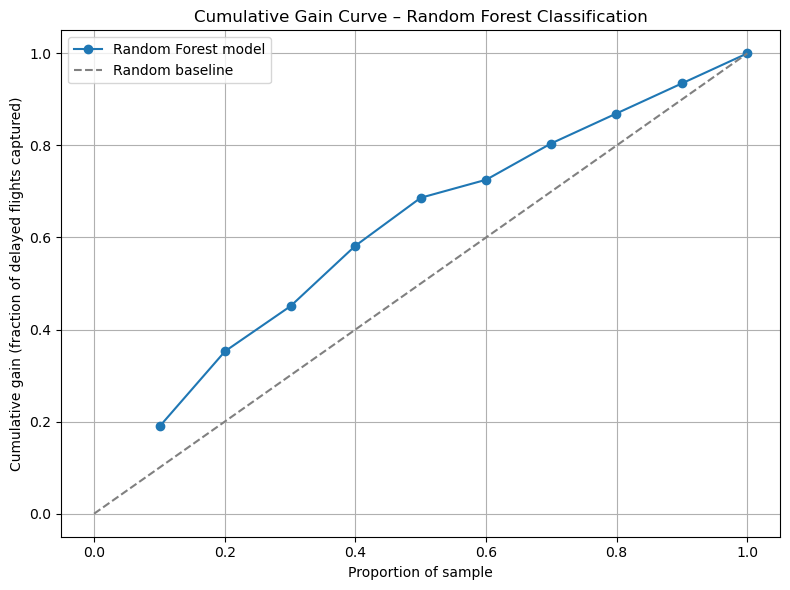

In [41]:
import matplotlib.pyplot as plt

# =========================
# 8) Cumulative Gain Curve
# =========================

# X-axis: percentage of sample contacted
gain_table["cum_perc_samples"] = gain_table["cum_n"] / gain_table["n"].sum()

plt.figure(figsize=(8, 6))
plt.plot(
    gain_table["cum_perc_samples"],
    gain_table["cum_gain"],
    marker="o",
    label="Random Forest model"
)

# Baseline (random model)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="gray",
    label="Random baseline"
)

plt.xlabel("Proportion of sample")
plt.ylabel("Cumulative gain (fraction of delayed flights captured)")
plt.title("Cumulative Gain Curve – Random Forest Classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
